# PINN for 1D Burgers' Equation

This notebook demonstrates how to solve the 1D Burgers' equation using a Physics-Informed Neural Network (PINN). The Burgers' equation is a fundamental partial differential equation (PDE) that incorporates both nonlinear convection and diffusion terms. It serves as a simplified model for more complex phenomena like turbulence and traffic flow.

### Problem Definition

- **PDE:** 
$$ \frac{\partial u}{\partial t} + u \frac{\partial u}{\partial x} = \nu \frac{\partial^2 u}{\partial x^2} $$
- **Computational Domain:** 
$$ x \in [-1, 1], \quad t \in [0, 1] $$
- **Initial Condition (IC):** 
$$ u(x, 0) = -\sin(\pi x) $$
- **Boundary Conditions (BCs):** 
$$ u(-1, t) = 0, \quad u(1, t) = 0 $$
- **Viscosity ($\nu$):** 
$$ \nu = \frac{0.01}{\pi} $$

We will use the `deepxde` library to construct the PINN, define the problem, and train the model.




In [6]:
import deepxde as dde
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set style for plots
sns.set_style("whitegrid")

# Define the viscosity parameter
nu = 0.01 / np.pi


### Stage 1: Defining the Geometry and PDE

First, we define the computational domain for the problem. For a time-dependent problem like this, we need to specify both the spatial and temporal domains.

- **Spatial Domain:** The problem is defined for `x` in `[-1, 1]`, which we represent using `dde.geometry.Interval`.
- **Temporal Domain:** The problem is defined for `t` in `[0, 1]`, represented by `dde.geometry.TimeDomain`.
- **Spatio-temporal Domain:** We combine these two using `dde.geometry.GeometryXTime` to create the full domain for training.


In [7]:
# 1. Define Geometry and Time Domain
geom = dde.geometry.Interval(-1, 1)
timedomain = dde.geometry.TimeDomain(0, 1)
geomtime = dde.geometry.GeometryXTime(geom, timedomain)


Next, we define the PDE residual. The PINN will be trained to minimize this residual, forcing the neural network's output to satisfy the Burgers' equation.

- The function `pde(x, u)` takes two arguments: `x` (a tensor with columns for x and t coordinates) and `u` (the network's output).
- We use `dde.grad.jacobian` and `dde.grad.hessian` to compute the necessary partial derivatives of `u`.
- The expression `u * du_x` represents the nonlinear convection term, a key feature of the Burgers' equation.
- The function returns the residual of the PDE, which is the amount by which the network's output fails to satisfy the equation.



In [ ]:
# 2. Define the PDE
def pde(x, u):
    """
    Defines the residual of the Burgers' equation.
    x is a 2D tensor where x[:, 0:1] is x and x[:, 1:2] is t.
    u is the neural network's output, representing the solution.
    """
    du_t = dde.grad.jacobian(u, x, i=0, j=1)  # First derivative of u with respect to the second variable (t)
    du_x = dde.grad.jacobian(u, x, i=0, j=0)  # First derivative of u with respect to the first variable (x)
    du_xx = dde.grad.hessian(u, x, i=0, j=0)   # Second derivative of u with respect to x
    
    # The nonlinear convection term is simply u * du_x
    return du_t + u * du_x - nu * du_xx


# 備註：關於 dde.grad.jacobian 和 dde.grad.hessian 中的 i 和 j 參數
# 
# i：指定要計算哪個輸出變量的偏導數
#    - 對於我們的問題，u 只有一個輸出，所以 i=0
#    - 如果有多個輸出變量（如 u1, u2, ...），則 i 指定第幾個輸出
# 
# j：指定要對哪個輸入變量進行求導
#    - j=0：對第一個輸入變量（x）求導
#    - j=1：對第二個輸入變量（t）求導
#    - 對於我們的輸入 x，其中 x[:, 0] 是空間坐標 x，x[:, 1] 是時間坐標 t
# 
# 因此：
# - du_t = dde.grad.jacobian(u, x, i=0, j=1)：對 u（第0個輸出）關於 t（第1個輸入）的偏導數 ∂u/∂t
# - du_x = dde.grad.jacobian(u, x, i=0, j=0)：對 u（第0個輸出）關於 x（第0個輸入）的偏導數 ∂u/∂x
# - du_xx = dde.grad.hessian(u, x, i=0, j=0)：對 u（第0個輸出）關於 x（第0個輸入）的二階偏導數 ∂²u/∂x²


### Stage 2: Defining Boundary and Initial Conditions

We must provide the network with the boundary conditions (BCs) and initial conditions (ICs) to ensure the solution is unique and physically correct.

- **Boundary Conditions:** We have Dirichlet boundary conditions `u(-1, t) = 0` and `u(1, t) = 0`. We define a `boundary` function to identify points on the spatial boundaries (`x=-1` or `x=1`) and use `dde.DirichletBC` to enforce the zero value.
- **Initial Condition:** We have an initial condition `u(x, 0) = -sin(πx)`. We use `dde.IC` to apply this condition to all points at `t=0`. To ensure compatibility with both CPU (NumPy) and GPU (Tensor) operations, we create a helper function that checks the input type and uses the appropriate `sin` function.




In [9]:
# 3. Define Boundary and Initial Conditions

# Boundary function to identify points on the spatial boundary (x=-1 or x=1)

def boundary(x, on_boundary):
    return on_boundary and (np.isclose(x[0], -1) or np.isclose(x[0], 1))
# Function for the initial condition, compatible with both NumPy and backend Tensors
def initial_condition_func(x):
    # Check the type of the input x to use the correct sin function
    if isinstance(x, np.ndarray):
        sin = np.sin
    else:
        sin = dde.backend.sin
    return -sin(np.pi * x[:, 0:1])

# Dirichlet boundary condition: u(-1, t) = u(1, t) = 0
bc = dde.DirichletBC(geomtime, lambda x: 0, boundary)

# 解釋 boundary 函數的寫法：
# 
# boundary 函數是用來識別哪些點位於空間邊界上（x=-1 或 x=1）
# 
# 函數定義：def boundary(_, on_boundary):
# - 第一個參數 _：通常是點的坐標 x，但這裡用下劃線表示我們不需要使用它
# - 第二個參數 on_boundary：這是 DeepXDE 自動提供的布爾值
#   - on_boundary=True：表示該點位於幾何體的邊界上
#   - on_boundary=False：表示該點位於幾何體的內部
# 
# return on_boundary 的意思：
# - 直接返回 DeepXDE 提供的邊界判斷結果
# - 這樣可以選中所有邊界點（在我們的例子中就是 x=-1 和 x=1 的點）
# 
# 如果我們想要更精確地控制邊界條件，也可以這樣寫：
# def boundary(x, on_boundary):
#     return on_boundary and (np.isclose(x[0], -1) or np.isclose(x[0], 1))
# 
# 但由於我們的幾何體是 [-1, 1] × [0, 1]，所有的空間邊界都需要應用相同的邊界條件，
# 所以簡單地返回 on_boundary 就足夠了


# Initial condition: u(x, 0) = -sin(pi * x)

def initial_boundary(x, on_initial):
    return on_initial and np.isclose(x[1], 0)
ic = dde.IC(geomtime, initial_condition_func, initial_boundary)


# 解釋 initial condition 中的 lambda _, on_initial: on_initial 寫法：
# 
# 在 DeepXDE 的 IC (Initial Condition) 中，第三個參數是用來定義
# 哪些點應該應用初始條件的函數
# 
# lambda _, on_initial: on_initial 的含義：
# - 第一個參數 _：通常是點的坐標 (x, t)，但這裡用下劃線表示我們不需要使用它
# - 第二個參數 on_initial：這是 DeepXDE 自動提供的布爾值
#   - on_initial=True：表示該點位於初始時間 t=0 上
#   - on_initial=False：表示該點不在初始時間上
# 
# return on_initial 的意思：
# - 直接返回 DeepXDE 提供的初始時間判斷結果
# - 這樣可以選中所有 t=0 時刻的點來應用初始條件
# 
# 這種寫法等價於：
# def initial_boundary(x, on_initial):
#     return on_initial
# 
# 或者更明確地寫：
# def initial_boundary(x, on_initial):
#     return on_initial and np.isclose(x[1], 0)  # x[1] 是時間坐標 t
# 
# 但由於 on_initial 已經精確地識別了 t=0 的點，
# 所以簡單地返回 on_initial 就足夠了



### Stage 3: Model Assembly and Training

Now we assemble the components and train the model.

- **Data Assembly:** We use `dde.data.TimePDE` to create the dataset, specifying the number of residual points in the domain, on the boundary, and for the initial condition. `num_test` is used to generate points for validation during training, although for problems without a known analytical solution, this metric primarily tracks convergence rather than true error.
- **Network Architecture:** A standard Feed-Forward Network (FNN) is used, with 2 input neurons (x, t), 3 hidden layers of 20 neurons each, and 1 output neuron (u).
- **Training Strategy:** We employ a two-phase training process:
  1.  **Adam Optimizer:** We first train for 15,000 iterations with the Adam optimizer and a learning rate of 1e-3. Adam is a robust first-order optimizer that quickly finds a good region in the loss landscape.
  2.  **L-BFGS Optimizer:** After the Adam optimization, we switch to L-BFGS. L-BFGS is a second-order optimizer that can achieve faster convergence and a lower loss value once the solution is already in a good basin of attraction. This fine-tuning step is crucial for many PINN applications.

  


In [ ]:
# 4. Assemble and Train the Model
data = dde.data.TimePDE(
    geomtime,
    pde,
    [bc, ic],
    num_domain=2540,
    num_boundary=80,
    num_initial=160,
    num_test=10000,
)

net = dde.nn.FNN([2] + [20] * 3 + [1], "tanh", "Glorot normal")

model = dde.Model(data, net)

# Phase 1: Train with Adam optimizer
model.compile("adam", lr=1e-3)
losshistory, train_state = model.train(iterations=15000, display_every=1000)

# After training, let's understand the loss components
# The loss array [8.15e-04, 2.66e-06, 9.21e-04] contains three elements:
# 1. PDE residual loss: Measures how well the PDE is satisfied in the domain
# 2. Boundary condition loss: Measures how well the boundary conditions are satisfied
# 3. Initial condition loss: Measures how well the initial condition is satisfied

print("Loss components after Adam optimization:")
print(f"PDE residual loss: {losshistory.loss_train[-1][0]:.2e}")
print(f"Boundary condition loss: {losshistory.loss_train[-1][1]:.2e}")
print(f"Initial condition loss: {losshistory.loss_train[-1][2]:.2e}")
print(f"Total train loss: {sum(losshistory.loss_train[-1]):.2e}")


Compiling model...
'compile' took 0.000096 s

Training model...

Step      Train loss                        Test loss                         Test metric
0         [3.63e-03, 2.32e-03, 5.50e-01]    [3.58e-03, 2.32e-03, 5.50e-01]    []  
1000      [4.46e-02, 6.18e-04, 5.57e-02]    [4.66e-02, 6.18e-04, 5.57e-02]    []  
2000      [3.31e-02, 1.11e-04, 4.51e-02]    [3.71e-02, 1.11e-04, 4.51e-02]    []  
3000      [2.36e-02, 1.01e-04, 2.94e-02]    [2.96e-02, 1.01e-04, 2.94e-02]    []  
4000      [1.15e-02, 3.40e-05, 8.25e-03]    [1.43e-02, 3.40e-05, 8.25e-03]    []  
5000      [5.80e-03, 1.38e-05, 3.25e-03]    [1.51e-02, 1.38e-05, 3.25e-03]    []  
6000      [4.67e-03, 5.70e-06, 2.33e-03]    [1.43e-02, 5.70e-06, 2.33e-03]    []  
7000      [3.68e-03, 3.86e-06, 1.78e-03]    [1.32e-02, 3.86e-06, 1.78e-03]    []  
8000      [2.81e-03, 3.90e-06, 1.42e-03]    [1.11e-02, 3.90e-06, 1.42e-03]    []  
9000      [2.66e-03, 4.45e-06, 1.18e-03]    [7.85e-03, 4.45e-06, 1.18e-03]    []  
10000     [1.82

In [54]:
# Phase 2: Refine with L-BFGS optimizer
model.compile("L-BFGS")
losshistory, train_state = model.train()


Compiling model...
'compile' took 0.000522 s

Training model...

Step      Train loss                        Test loss                         Test metric
15000     [9.90e-04, 2.66e-06, 6.30e-04]    [3.82e-03, 2.66e-06, 6.30e-04]    []  
15004     [9.90e-04, 2.66e-06, 6.30e-04]    [3.83e-03, 2.66e-06, 6.30e-04]    []  

Best model at step 15004:
  train loss: 1.62e-03
  test loss: 4.46e-03
  test metric: []

'train' took 0.182724 s



### Stage 4: Visualize the Solution

After training, we visualize the results to understand the behavior of the learned solution.

- **Loss History:** Plotting the loss history helps verify that the model has converged properly.
- **Solution Heatmap:** A 2D heatmap of `u(x, t)` provides a comprehensive view of the solution over the entire spatio-temporal domain. It allows us to observe the wave propagation and diffusion effects.
- **Time Snapshots:** Plotting the solution `u(x)` at different time instances (`t = 0.0, 0.25, ..., 1.0`) clearly shows how the initial sine wave profile evolves over time, steepening due to the nonlinear term and dissipating due to the diffusion term.


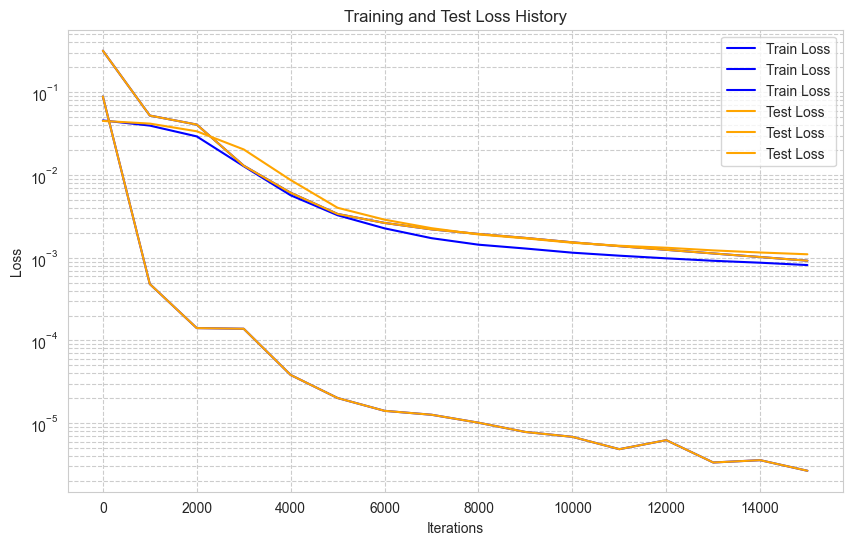

In [25]:
# Plot the loss history
plt.figure(figsize=(10, 6))
train_loss = np.array(losshistory.loss_train)
test_loss = np.array(losshistory.loss_test)
steps = losshistory.steps

plt.plot(steps, train_loss, label="Train Loss", color='blue')
plt.plot(steps, test_loss, label="Test Loss", color='orange')

plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.yscale("log")
plt.title("Training and Test Loss History")
plt.legend()
plt.grid(True, which="both", ls="--")
plt.show()



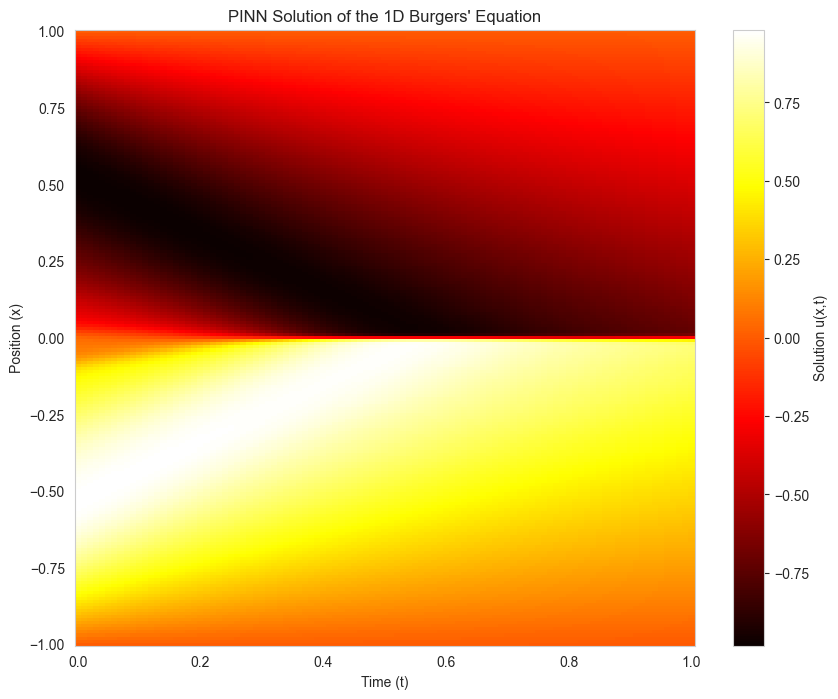

In [18]:
# Create a grid for prediction
x = np.linspace(-1, 1, 201)
t = np.linspace(0, 1, 101)
X, T = np.meshgrid(x, t)
xt_test = np.vstack((X.flatten(), T.flatten())).T

# Predict the solution on the grid
u_pred = model.predict(xt_test)
U_pred = u_pred.reshape(X.shape)

# Plot the 2D heatmap of the solution
plt.figure(figsize=(10, 8))
plt.pcolormesh(T, X, U_pred, shading='auto', cmap='hot')
plt.colorbar(label="Solution u(x,t)")
plt.xlabel("Time (t)")
plt.ylabel("Position (x)")
plt.title("PINN Solution of the 1D Burgers' Equation")
plt.show()


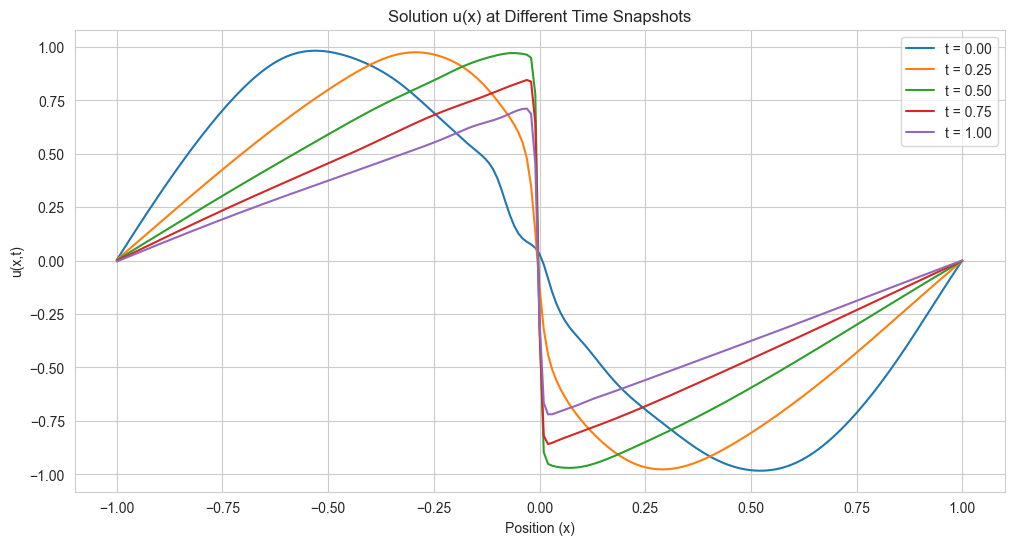

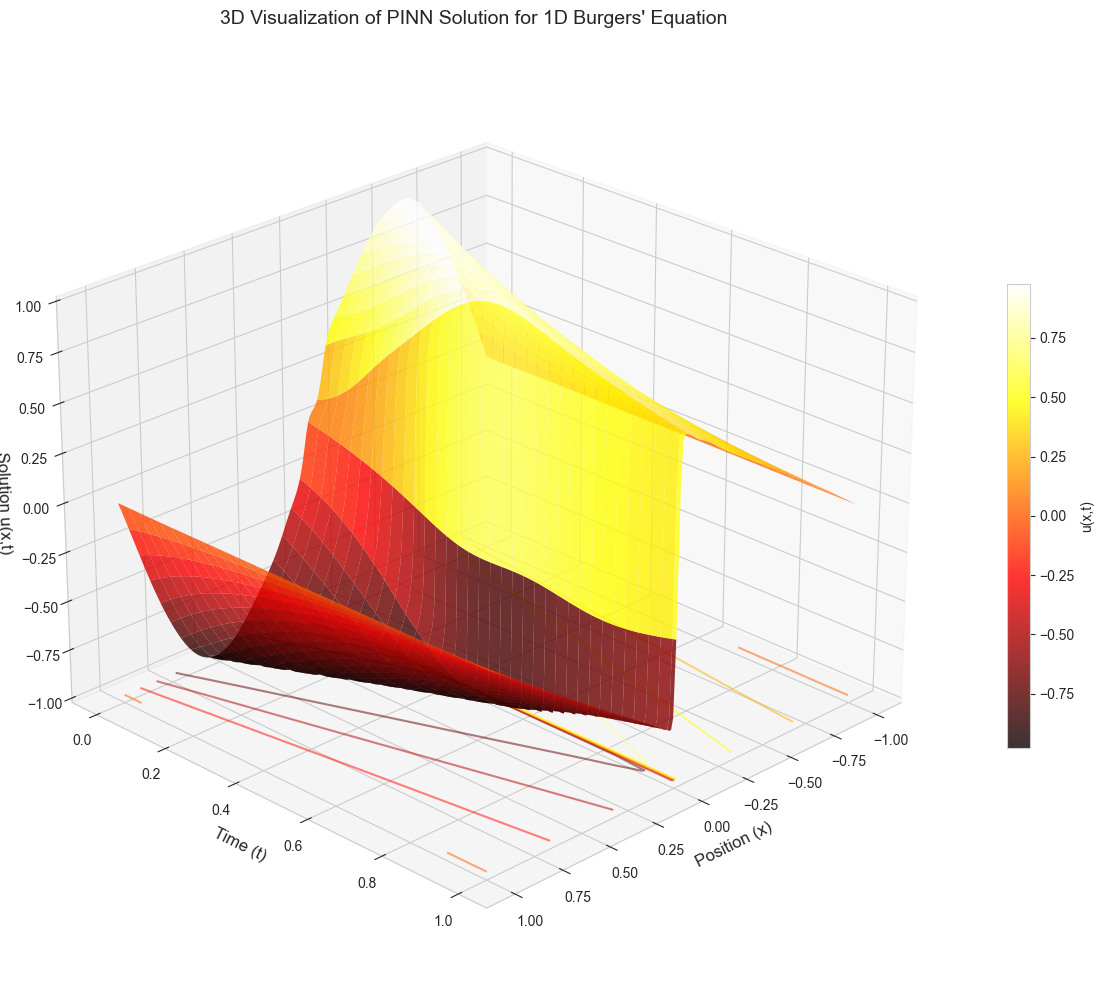

In [39]:
# Plot snapshots at different time steps
plt.figure(figsize=(12, 6))
time_snapshots = [0.0, 0.25, 0.5, 0.75, 1.0]
for i, t_val in enumerate(time_snapshots):
    # Find the index in the time array closest to the snapshot time
    t_index = np.argmin(np.abs(t - t_val))
    # Plot the solution u(x) at this time - correct indexing: U_pred[time_index, :]
    plt.plot(x, U_pred[t_index, :], label=f't = {t_val:.2f}')

plt.title("Solution u(x) at Different Time Snapshots")
plt.xlabel("Position (x)")
plt.ylabel("u(x,t)")
plt.legend()
plt.grid(True)
plt.show()

# %% cell 16 code

# Create 3D surface plot
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(14, 10))
ax = fig.add_subplot(111, projection='3d')

# Create the 3D surface plot
surf = ax.plot_surface(X, T, U_pred, cmap='hot', alpha=0.8, 
                      linewidth=0, antialiased=True)

# Add contour lines on the bottom
contours = ax.contour(X, T, U_pred, zdir='z', offset=U_pred.min(), 
                     cmap='hot', alpha=0.5)

# Customize the plot
ax.set_xlabel('Position (x)', fontsize=12)
ax.set_ylabel('Time (t)', fontsize=12)
ax.set_zlabel('Solution u(x,t)', fontsize=12)
ax.set_title('3D Visualization of PINN Solution for 1D Burgers\' Equation', 
             fontsize=14, pad=20)

# Add colorbar
fig.colorbar(surf, ax=ax, shrink=0.5, aspect=20, label='u(x,t)')

# Set viewing angle
ax.view_init(elev=25, azim=45)

plt.tight_layout()
plt.show()
